In [75]:
# Basic imports
import os
master_dir  = os.getcwd()  # the main working directory
data_dir    = os.path.join(master_dir, "Data")  # sub directory where we save data files
plots_dir   = os.path.join(master_dir, "Plots")  # sub directory where we save plots
import numpy as np
import pandas as pd

from typing import Callable, Any
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['text.usetex'] = False
import seaborn as sn
from  matplotlib.colors import LinearSegmentedColormap
my_cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
my_cmap_r=LinearSegmentedColormap.from_list('rg',["g", "w", "r"], N=256) 

Hyperparams for plotting:

In [20]:
TITLE = True
SAVE = False

# General classes and functions

In [2]:
def distance(v1: np.array, v2: np.array) -> float:
    """Computes Euclidan distance between two vectors.

    Args:
        v1 (np.array): First vector.
        v2 (np.array): Second vector.

    Returns:
        float: Euclidean distance between the vectors.
    """
    
    return np.sqrt(np.sum((v1 - v2)**2))

In [3]:
class Trajectory:
    """Class for trajectories obtained from Hopfield networks."""
    
    def __init__(self, x: np.array, y: np.array, z: np.array = None):
        """Initialize the object.

        Args:
            x (np.array): x positions of the trajectory
            y (np.array): y positions of the trajectory
            z (np.array, optional): z positions of the trajectory, optional if in 2D
        """
        
        self.x = x
        self.y = y
        self.z = z
        
        # In case we are dealing with the 2D case
        if self.z is None:
            self.path = np.array([[x[i], y[i]] for i in range(len(x))])
        
        # For the 3D case:
        else: 
            self.path = np.array([[x[i], y[i], z[i]] for i in range(len(x))])
        
        self.start = self.path[0]
        self.end = self.path[-1]

In [4]:
class Hop:
    """
    Class for discussing results from trajectories of a Hopfield network.
    """
    
    def __init__(self, df: pd.DataFrame, dim: int) -> None:
        """Initialization.

        Args:
            df (pd.DataFrame): Dataframe storing the different trajectories obtained from a Hopfield network.
            dim (int): Number of dimensions we work in (2D or 3D)
        """
        
        # Define fields
        self.trajectories = []
        self.attractors   = []
        
        # Dimensionality
        self.dim = dim
        
        # Initialize fields: process all data and get the attractors of the network
        self.compile_data(df)
        self.compile_attractors()
        
        
    def append(self, trajectory: Trajectory) -> None:
        """Append a trajectory from the Hopfield network

        Args:
            trajectory (Trajectory): New trajectory from the Hopfield network to be added to the discussion.
        """
        
        self.trajectories.append(trajectory)
        
    def compile_attractors(self, threshold: float = 0.01) -> None:
        """Gather attractors of the network as observed from the flow conditions.

        Args:
            threshold (float, optional): Threshold for distance separation to classify attractors. Defaults to 0.01.
        """
        
        # Save all the attractors, already remove exact duplicates
        attractors = np.unique([traj.end for traj in self.trajectories], axis=0)
        # Still have to filter out duplicates very close to each other, base on distance and threshold
        saved_list = [attractors[0]]
        for attr in attractors:
            # Compute the distances between saved attractors and next attractor
            closest_distance = np.min([distance(attr, saved_attr) for saved_attr in saved_list])
            # If this distance is above the threshold, attractors are different
            if closest_distance > threshold:
                saved_list.append(attr)
                
        # Convert to numpy array and save
        self.attractors = np.array(saved_list)
            
        
    def compile_data(self, df: pd.DataFrame) -> None:
        """Compile the trajectory data and save it as trajectories.

        Args:
            df (pd.DataFrame): DataFrame of trajectories. 
        """
        
        # Check how many trajectories are in the CSV file (1 trajectory = D adjacent rows, D = dimensionality)
        nb_trajectories = len(df) // self.dim
        
        for i in range(nb_trajectories):
            # Certainly get the next x and y
            x, y = df.loc[self.dim*i].values, df.loc[self.dim*i + 1].values
            # Check if there is a z value or not
            if self.dim == 2:
                z = None
            else:
                z = df.loc[2*i + 2].values
            # Create trajectory object and save it
            new_trajectory = Trajectory(x, y, z)
            self.append(new_trajectory)

In [12]:
def is_in(point: np.array, list_of_points: np.array) -> None:
    """Simple auxiliary function that checks whether a given point as numpy array is within a given list of points by checking the coordinates

    Args:
        point (np.array): Single point, a numpy array, that has to be checked against a list of points.
        list_of_points (np.array): A list of points to compare against point. 
    """
    
    # Loop over all points of the list of points
    for other_point in list_of_points:
        # If all coordinates agree, it is among the list
        if np.all(point == other_point):
            return True
    
    return False

For the plots below, we define a few colors and their order to easily group trajectories that end at the same attractor state.

In [13]:
COLORS = ["red", "blue", "orange", "green", "cadetblue", "magenta", "purple", "lightslategrey", "darkred"]

In [14]:
def get_color(end_point: np.array, attractors: np.array) -> str:
    """Gives a color to a point based on the distance to the attractors. 

    Args:
        end_point (np.array): End point of a trajectory, for which we want to determine the closest attractor or closest color.
        attractors (np.array): List of attractor locations to compare distances.

    Returns:
        str: Description of the color used as encoding for the closest attractor
    """
    
    # Get the Euclidean distances between the end point and all attractors
    distances = [distance(end_point, attr) for attr in attractors]
    # Get the index of the attractor closest to endpoint
    best_index = np.argmin(distances)
    
    return COLORS[best_index]

In [15]:
def compute_convergence_index(trajectory: Trajectory, attractors):
    """Compute the index at which the trajectory  converged at an attractor.

    Args:
        trajectory (Trajectory): The specific trajectory under consideration.
        attractors (_type_): All attractors we observed.

    Returns:
        _type_: _description_
    """
    path = trajectory.path
    for i in range(len(path)):
        if is_in(path[i], attractors):
            return i

# 2D Hopfield network

In this first example, we consider the 2D Hopfield network that is provided by the assignment. The dynamical system that is learnt by the network is
\begin{equation*}
    \boldsymbol{x}_{t+1} = \texttt{satlins}\left[\text{diag}\left({1.1618, 1.1618}\right) \cdot \boldsymbol{x}_{t} \right] \, 
\end{equation*}
Note, in particular, that there is no bias term -- this will introduce new spurious attractors, such as the origin.

In [16]:
# Import the data for comparison
df = pd.read_csv(os.path.join(data_dir, "hop_2D_trajectories.csv"), header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-0.9,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,0.8,0.929467,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
878,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
879,0.9,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
880,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1


Process a 2D dataframe containing the trajectories and information into a `Hop` object:

In [17]:
hop = Hop(df, 2)

Show the attractors that we found within this network:

In [18]:
print(hop.attractors)
print(f"There are {len(hop.attractors)} attractors in this Hopfield network.")

[[-1. -1.]
 [-1.  0.]
 [-1.  1.]
 [ 0. -1.]
 [ 0.  0.]
 [ 0.  1.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]]
There are 9 attractors in this Hopfield network.


Now we make a plot where we show the entire trajectories of those initial conditions and colour them based on the attractors where they end, which are plotted by crosses in the same color.

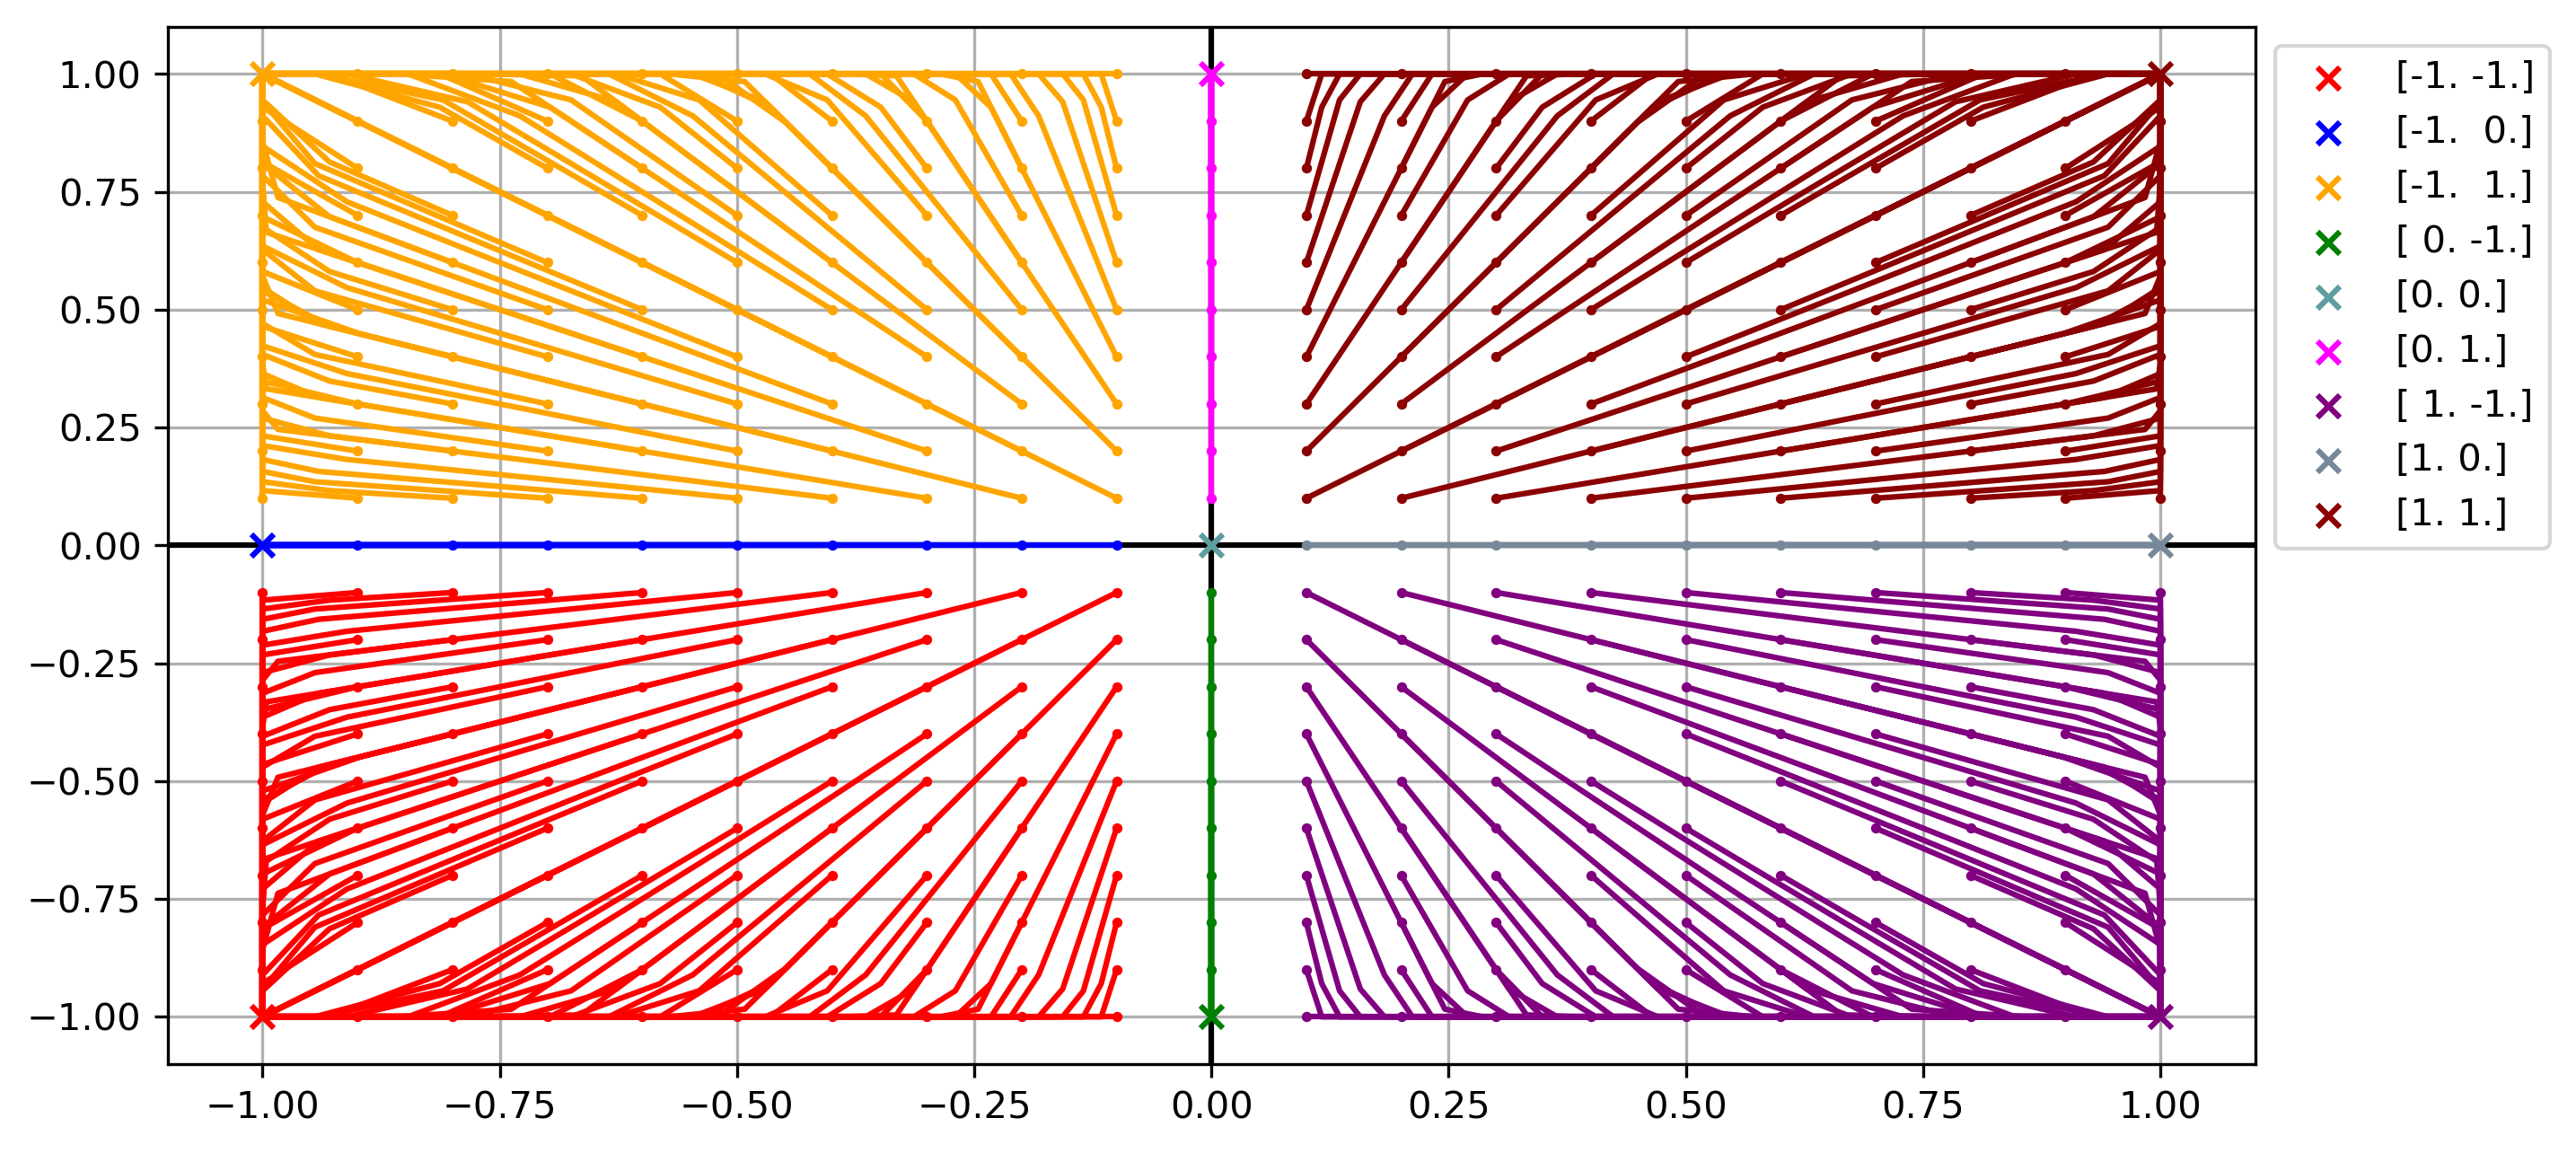

In [32]:
delta = 0.1

# Plot the end result of each trajectory
for trajectory in hop.trajectories:
    # Do not plot the trajectories that start at an attractor - will be plotted separately
    if is_in(trajectory.start, hop.attractors):
        continue
    plt.plot(trajectory.path[:, 0], trajectory.path[:, 1], color = get_color(trajectory.end, hop.attractors), zorder = 100)
    plt.scatter(trajectory.start[0], trajectory.start[1], color = get_color(trajectory.end, hop.attractors), s=3, zorder = 100)
   
# Plot the attractors separately
for i, attr in enumerate(hop.attractors):
    plt.scatter(attr[0], attr[1], color = COLORS[i], label = str(attr), marker="x", zorder = 100)
# Plot each attractor for the color coding 
plt.grid()
plt.legend(bbox_to_anchor=(1.15, 1))  # loc='right', 
plt.xlim(-1-delta, 1+delta)
plt.ylim(-1-delta, 1+delta)
plt.axhline(0, color="black")
plt.axvline(0, color="black")
plt.savefig(os.path.join(plots_dir, "Hop2D_trajectories_coloured.pdf"), bbox_inches='tight')
plt.show()

We also answer the question: how many iterations are needed to arrive at the attractor states?

In [33]:
indices = []
for trajectory in hop.trajectories:
    indices.append(compute_convergence_index(trajectory, hop.attractors))
print(f"Average number of iterations: {np.mean(indices)} with stdv {np.std(indices)}")

Average number of iterations: 8.16326530612245 with stdv 4.755291812510529


# 3D Hopfield network

In a second example, we consider a similar network but in three dimensions. The dynamical system learnt by the network is
\begin{equation*}
    \boldsymbol{x}_{t+1} = \texttt{satlins}\left( \begin{bmatrix} \phantom{-}0.8489 & \phantom{-}0.3129 &  -0.3129 \\ \phantom{-}0.3129 & \phantom{-}0.8489 & \phantom{-}0.3129 \\ -0.3129 & \phantom{-}0.3129 & \phantom{-}0.8489 \end{bmatrix} \cdot \boldsymbol{x}_{t} + \begin{bmatrix} \phantom{-}0.2849 \\ -0.2849 \\ \phantom{-}0.2849 \end{bmatrix}\right) \, ,
\end{equation*}
We again load in the data as we processed it in Matlab.

In [34]:
# Import the data for comparison
df = pd.read_csv(os.path.join(data_dir, "hop_3D_trajectories.csv"), header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,-0.750,-0.351847,-0.216650,-0.144181,-0.105334,-0.084512,-0.073350,-0.067367,-0.064160,-0.062441,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-0.750,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-0.750,-0.351847,-0.216650,-0.144181,-0.105334,-0.084512,-0.073350,-0.067367,-0.064160,-0.062441,...,1,1,1,1,1,1,1,1,1,1
3,-0.750,-0.234509,-0.153754,-0.110466,-0.087262,-0.074824,-0.068157,-0.064584,-0.062668,-0.061641,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-0.375,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0.375,0.502850,0.645313,0.809475,0.999902,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
371,0.750,0.804214,0.873279,0.954876,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
372,0.750,0.921552,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1
373,0.750,0.821199,0.989001,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,1,1,1,1,1,1,1,1,1


Process a 3D dataframe containing all the trajectories and information on this network:

In [35]:
hop = Hop(df, 3)

Again print the attractors that we found here:

In [36]:
print(hop.attractors)
print(f"There are {len(hop.attractors)} attractors in this Hopfield network.")

[[-1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1. -1.]
 [ 1. -1.  1.]
 [ 1.  1. -1.]
 [ 1.  1.  1.]]
There are 6 attractors in this Hopfield network.


Make a plot:

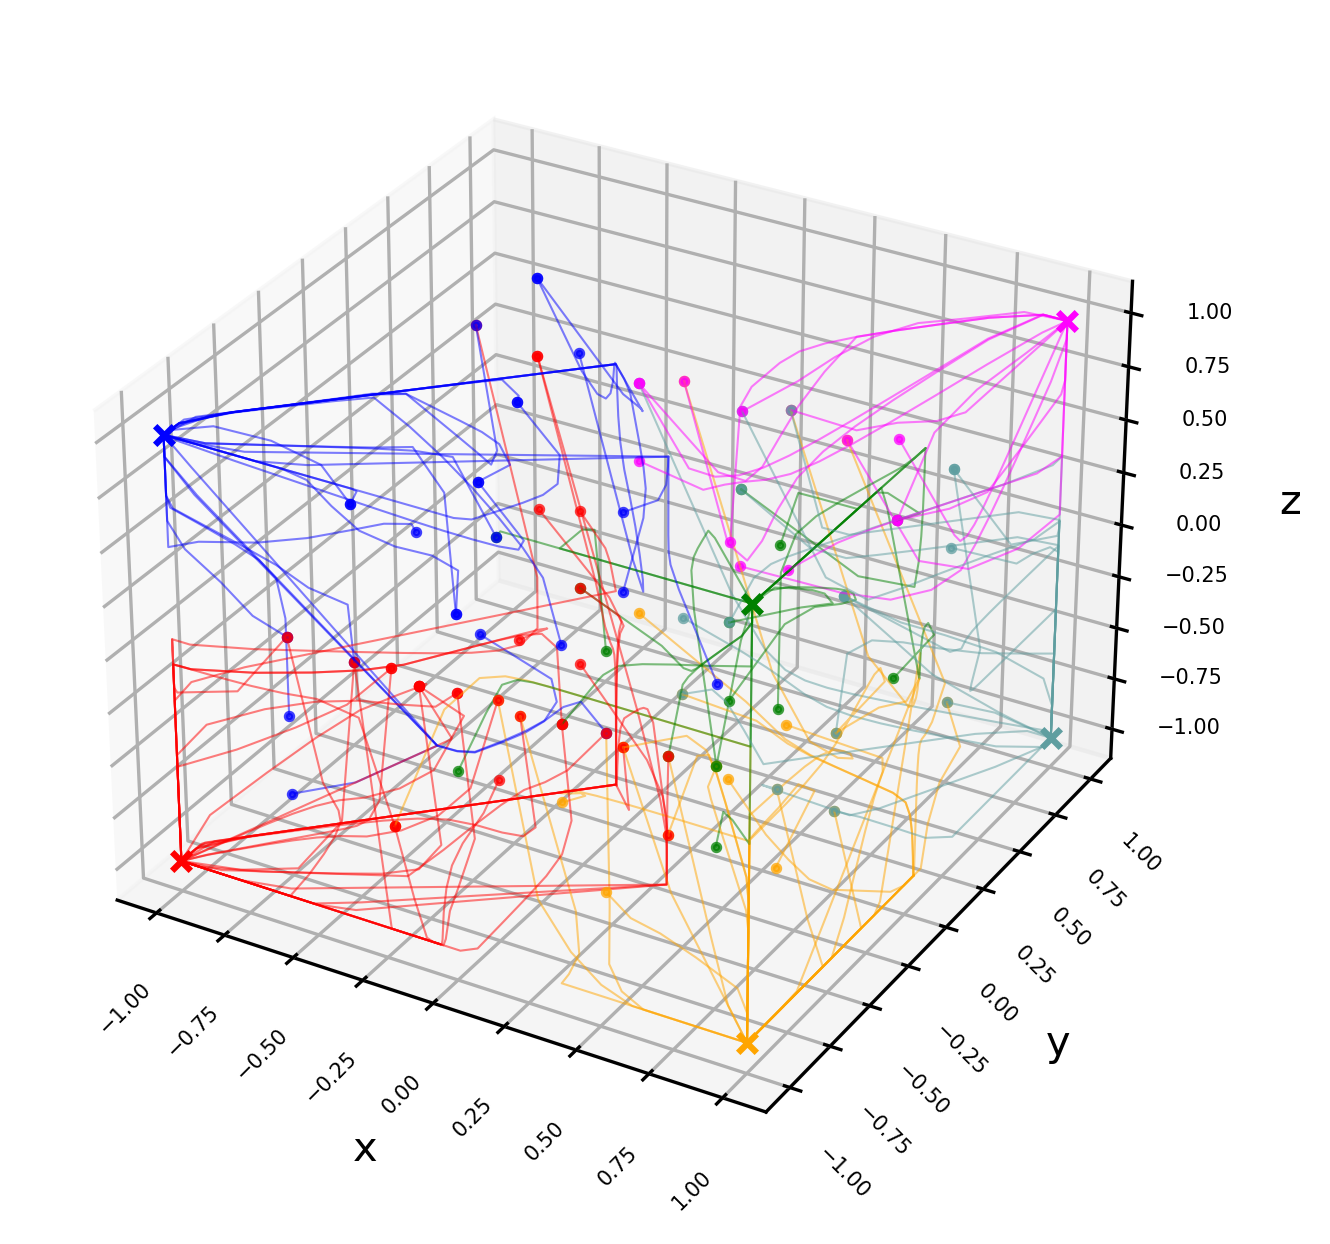

In [37]:
delta = 0.1

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')

# Plot the end result of each trajectory
for trajectory in hop.trajectories:
    if is_in(trajectory.start, hop.attractors):
        continue
    # Get color based on distance to attactors
    color = get_color(trajectory.end, hop.attractors)
    ax.scatter3D(trajectory.start[0], trajectory.start[1], trajectory.start[2], color = color, s = 3, alpha=0.75, zorder = 100)
    ax.plot3D(trajectory.path[:, 0], trajectory.path[:, 1], trajectory.path[:, 2], lw = 0.5, color = color, alpha=0.5, zorder = 100)
   
# Plot the attractors separately
for i, attr in enumerate(hop.attractors):
    ax.scatter3D(attr[0], attr[1], attr[2], color = COLORS[i], marker="x", zorder = 100)
# Plot each attractor for the color coding 
ax.grid()
ax.set_xlim(-1-delta, 1+delta)
ax.set_ylim(-1-delta, 1+delta)
ax.set_zlim(-1-delta, 1+delta)
# Set the axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# Rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# Rotate y-tick labels
for tick in ax.get_yticklabels():
    tick.set_rotation(-45)
# Decrease the size of the ticks for each axis
lab_size = 5
ax.tick_params(axis='x', which='both', labelsize=lab_size)
ax.tick_params(axis='y', which='both', labelsize=lab_size)
ax.tick_params(axis='z', which='both', labelsize=lab_size)
plt.savefig(os.path.join(plots_dir, "Hop3D_trajectories_coloured.pdf"), bbox_inches='tight')

plt.show()

We check explicitly that the two other "corner points" are no fixed points: we obtain the dynamical system that is learnt by the Hopfield network in this example and save the values here. The model is $x_{t+1} = Ax_{t} + b$.

In [40]:
A = np.array([0.8489, 0.3129, -0.3129, 0.3129, 0.8489, 0.3129, -0.3129, 0.3129, 0.8489]).reshape(3, 3) 
b = np.array([0.2849, -0.2849, 0.2849]).reshape(3, 1)

In [41]:
def is_fixed_point(point: np.array, weight: np.array, bias: np.array, threshold: float = 1e-4):
    """Simple auxiliary function to check if a certain point is a fixed point of the dynamical system x' = Ax+b.

    Args:
        point (np.array): Point we wish to check as potential fixed point of the dynamical system.
        weight (np.array): Matrix A of the dynamical system.
        bias (np.array): Matrix b of the dynamical system.
        threshold (float, optional): Threshold value as difference between x and Ax+b before we consider them close enough to be "equal". Defaults to 1e-4.

    Returns:
        _type_: _description_
    """
    # Compute the value at the next iteration
    next = np.matmul(weight, point) + bias
    # Check if distance is below our threshold
    if distance(point, next) < threshold:
        return True
    else:
        return False

In [42]:
#1 - first corner point
point = np.array([-1, 1, -1]).reshape(3, 1)
true_false = is_fixed_point(point, A, b)
print(f"{point.flatten()} is a fixed point? {true_false}")
#2 - second corner point
point = np.array([-1, 1, 1]).reshape(3, 1)
true_false = is_fixed_point(point, A, b)
print(f"{point.flatten()} is a fixed point? {true_false}")

[-1  1 -1] is a fixed point? False
[-1  1  1] is a fixed point? False


Now, we answer the question, how many iterations does it take before reaching the final state?

In [43]:
indices = []
for trajectory in hop.trajectories:
    indices.append(compute_convergence_index(trajectory, hop.attractors))
print(f"Average number of iterations: {np.mean(indices), np.std(indices)}")

Average number of iterations: (108.344, 110.92787595550544)


# Hopfield digits recognition

In this final example, we consider the Hopfield network that learned to recognize the handwritten digits. We did a few experiments in Matlab for varying number of iterations that the network is allowed to run and varying degrees of noise that get added to the data. We load those values, which were stored as a CSV, into our program:

In [110]:
# Import the data for comparison
df = pd.read_csv(os.path.join(data_dir, "hopdigits_results.csv"), names=["Noise", "Iterations", "Correct", "Comment"])
df

,Noise,Iterations,Correct,Comment
0,1,50,10,
1,1,100,10,
2,1,500,10,
3,3,50,10,
4,3,100,10,
5,3,500,10,
6,5,50,8,"5 became 3, 8 became 6"
7,5,100,9,4 became 7
8,5,500,10,
9,7,50,8,"5 became 9, 8 became 2"


In [111]:
# Reshape into a matrix for plotting
noise_values = np.unique(df["Noise"].values)
iteration_values = np.unique(df["Iterations"].values)
correct_values = df["Correct"].values.reshape((len(noise_values), len(iteration_values)))

We will turn this data into a more convenient format in order to create a matrix that simplifies plotting:

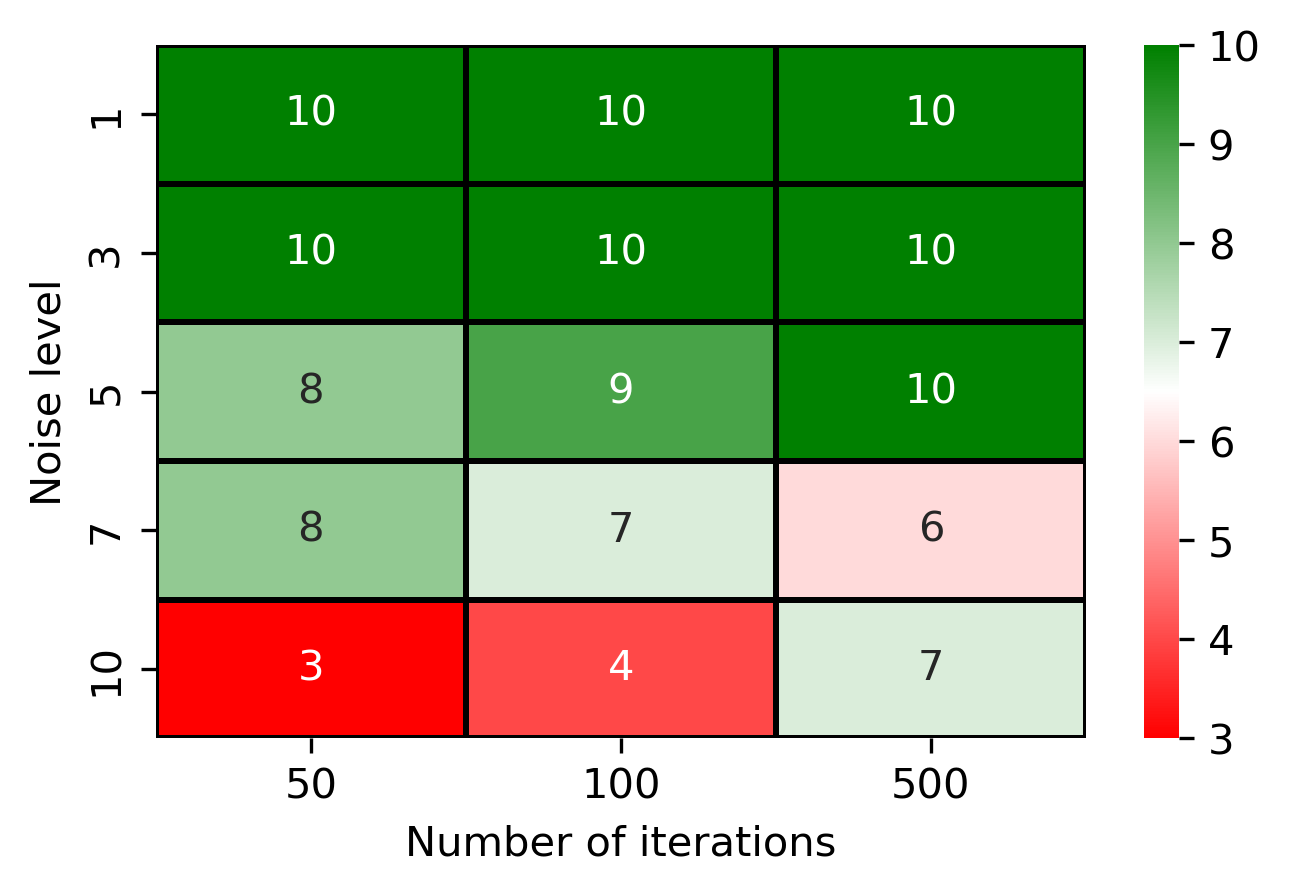

In [112]:
df_for_plot = pd.DataFrame(correct_values, index = noise_values, columns = iteration_values)
df_for_plot
plt.figure(figsize = (5,3))
sn.heatmap(df_for_plot, annot=True, cmap=my_cmap, linewidths=1, linecolor='black')
plt.xlabel("Number of iterations")
plt.ylabel("Noise level")
plt.savefig(os.path.join(plots_dir, "hopdigits_reconstructions.pdf"), bbox_inches = "tight")
plt.show()

# RNN for laser predictions

In [113]:
df = pd.read_csv(os.path.join(data_dir, "RNN_results.csv"))
# df = pd.read_csv("RNN_results.csv")
hidden_values = pd.unique(df["Hidden"].values)
p_values = pd.unique(df["p"].values)
all_mean = df.groupby(["Hidden", "p"]).mean()
all_std = df.groupby(["Hidden", "p"]).std()

Store the information as a 2D matrix for plotting:

In [114]:
validation_matrix = all_mean["Val MSE"].values.reshape((len(hidden_values), len(p_values)))
test_matrix = all_mean["Test MSE"].values.reshape((len(hidden_values), len(p_values)))

Plot the validation and test errors

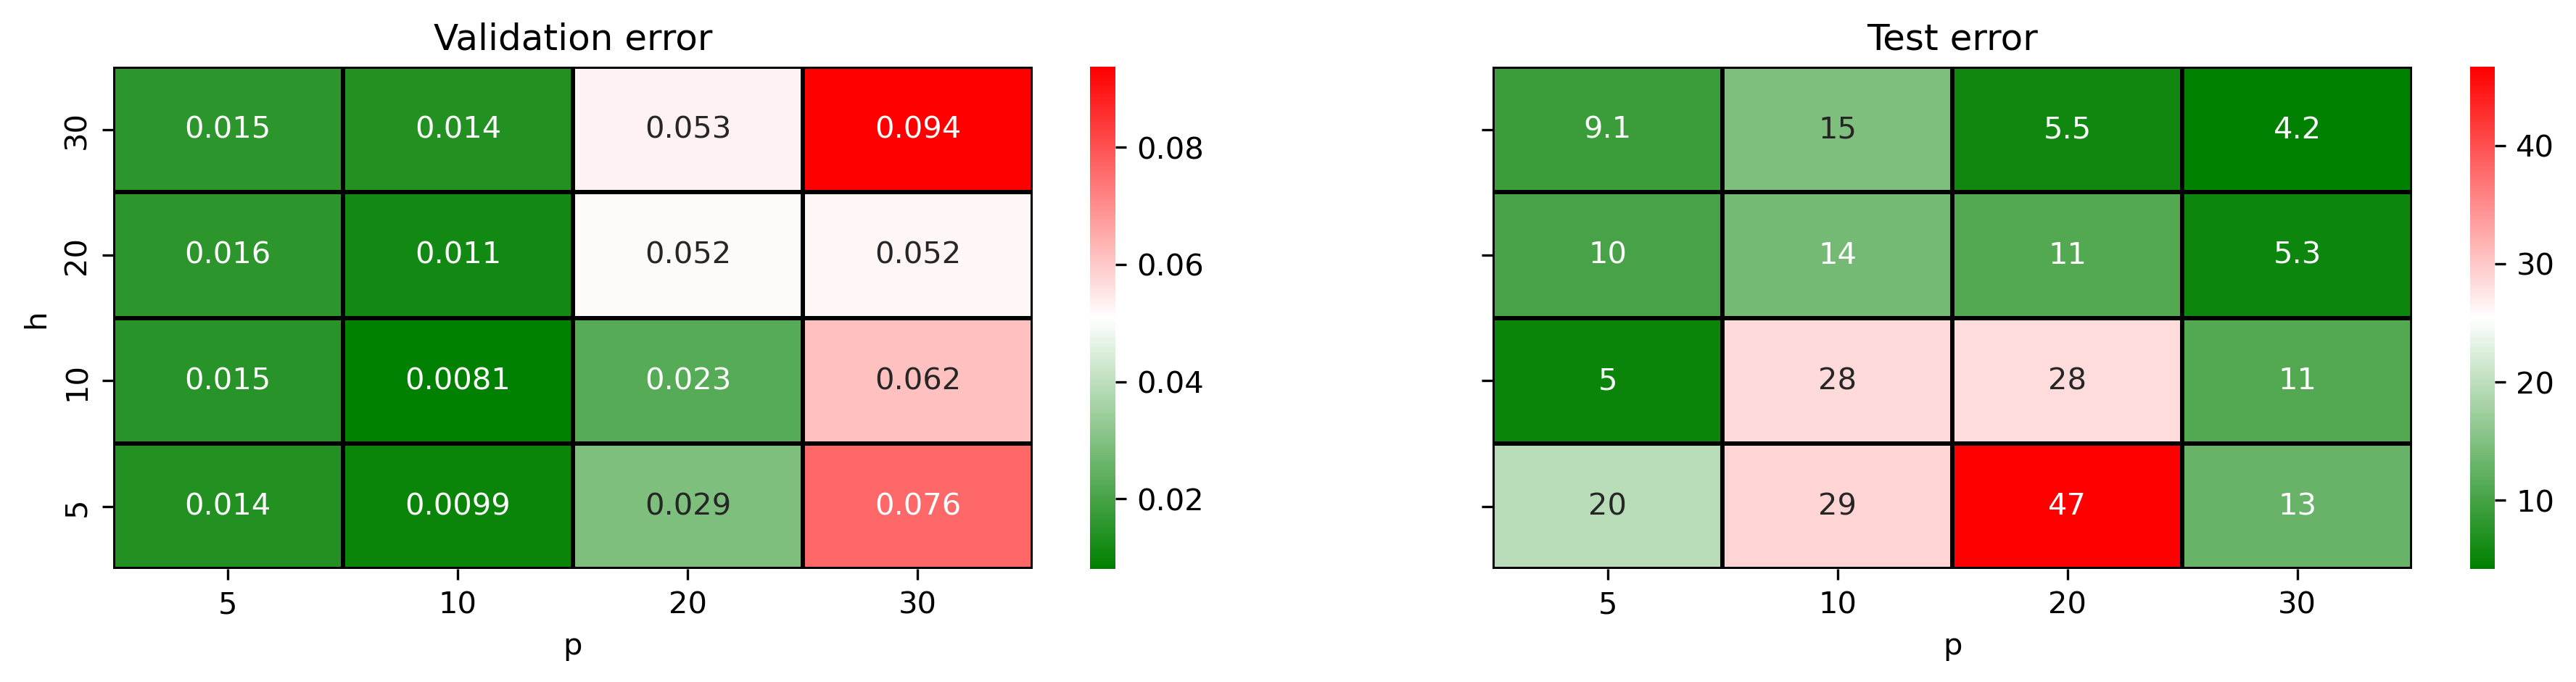

In [115]:
fig, axs = plt.subplots(1,2,figsize=(15,3), sharey=True)
plt.subplot(121)
df_for_plot = pd.DataFrame(validation_matrix, index = hidden_values, columns = p_values)
ax = sn.heatmap(df_for_plot, annot=True, cmap=my_cmap_r, linewidths=1, linecolor='black')
ax.invert_yaxis()
plt.xlabel("p")
plt.ylabel("h")
plt.title("Validation error")
plt.subplot(122)
df_for_plot = pd.DataFrame(test_matrix, index = hidden_values, columns = p_values)
ax = sn.heatmap(df_for_plot, annot=True, cmap=my_cmap_r, linewidths=1, linecolor='black')
ax.invert_yaxis()
plt.xlabel("p")
# plt.ylabel("h")
plt.title("Test error")
plt.savefig(os.path.join(plots_dir, "RNN_validation_test.pdf"), bbox_inches = "tight")
plt.show()

Make a plot of the predictions on the test set

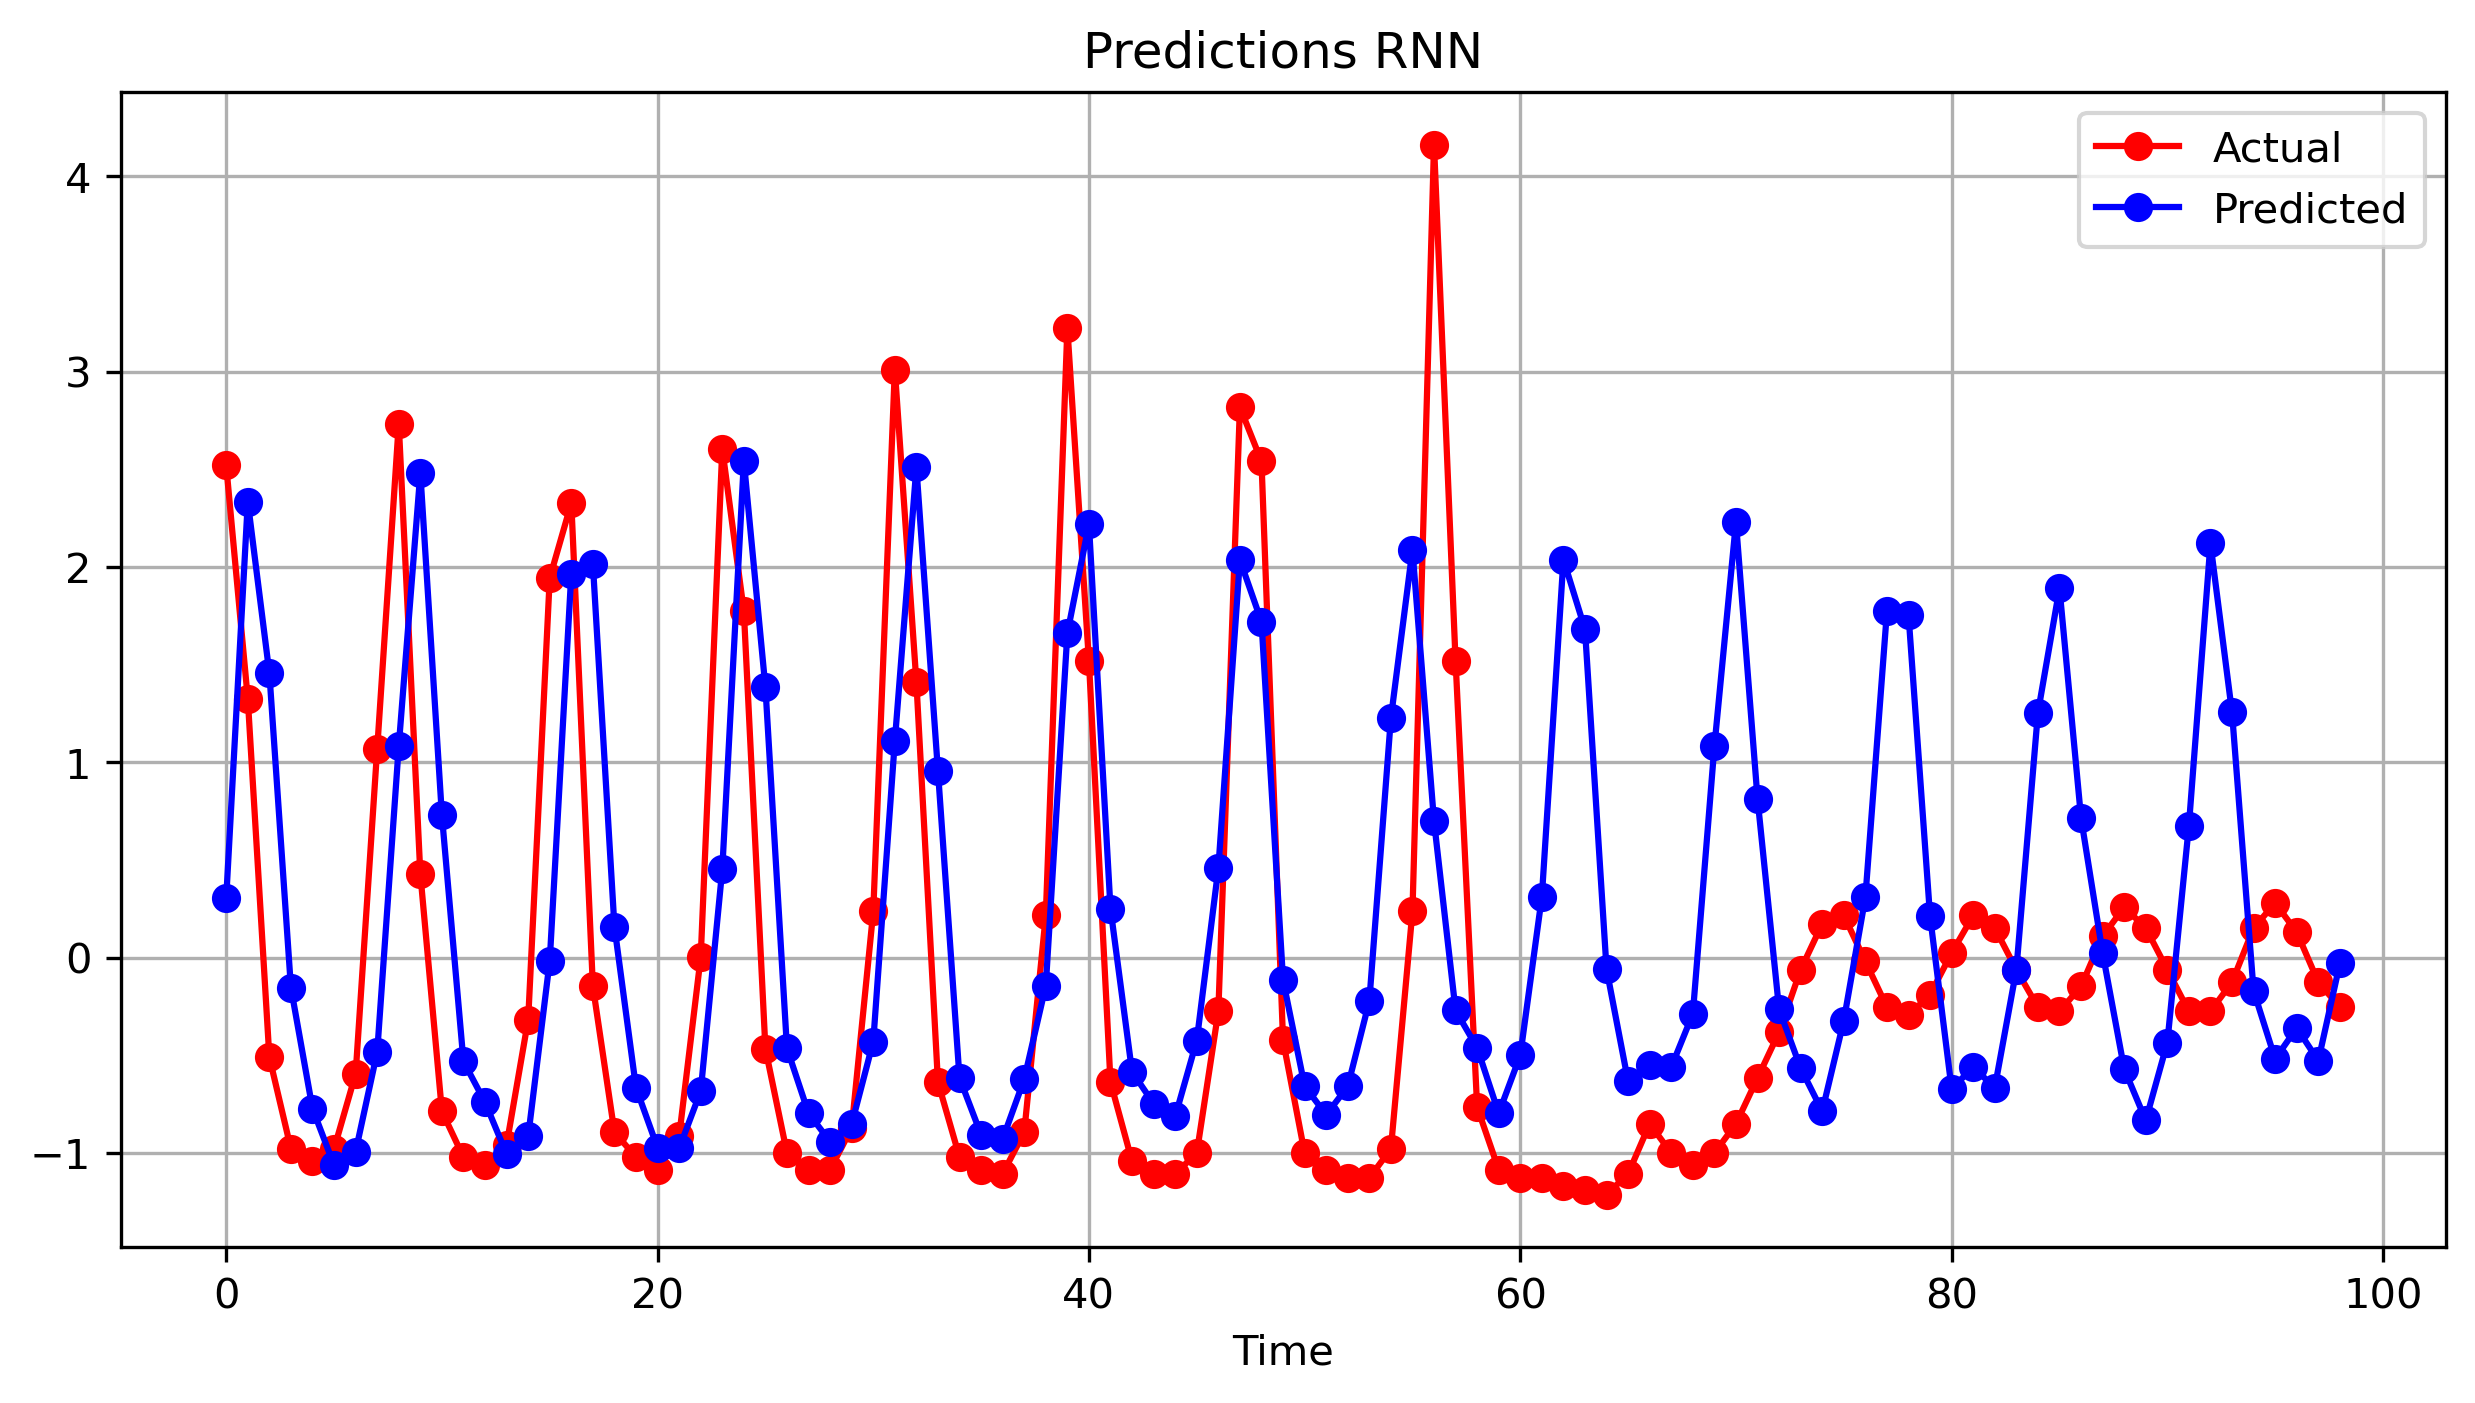

In [117]:
predictions = pd.read_csv(os.path.join(data_dir, "predictions_RNN.csv")).values
test_data = pd.read_csv(os.path.join(data_dir, "test_data_RNN.csv")).values
plt.plot(test_data, '-o', color="red", label="Actual")
plt.plot(predictions, '-o', color="blue", label="Predicted")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.title("Predictions RNN")
if SAVE:
    plt.savefig(os.path.join(plots_dir, "RNN_predictions.pdf"), bbox_inches='tight')
plt.show()

# LSTM